# ARIMA MODEL

We will build a prediction model. Since the test set provided does not contain the meta caracteristics, we will use only the time series themselves and eventualy the variables related to the product id.

In [968]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.metrics import mean_squared_error
import math

In [969]:
product = pd.read_pickle('./datasets/train_labeled_product_series.pkl')
meta = pd.read_pickle('./datasets/train_meta_series.pkl')
dt = pd.merge(left = product, right = meta, left_on = 'date', right_on= 'date')

### DATA ANALYSIS

Lets look at a simplified breakdown of the product series taking advantage of the types we clustered them in

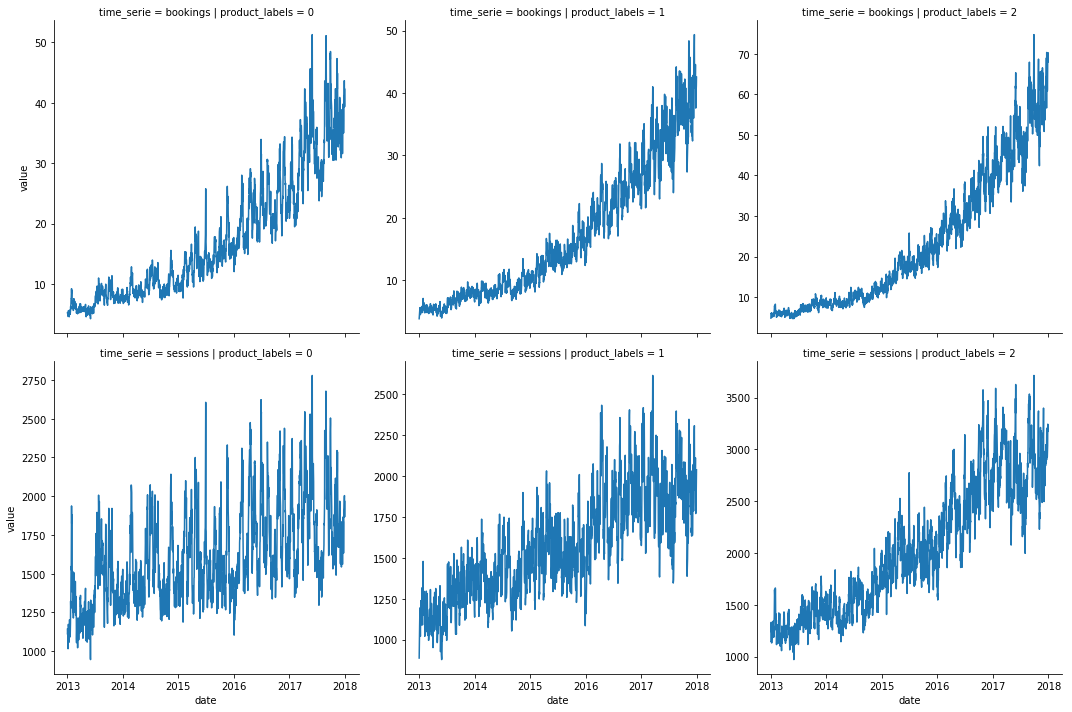

In [970]:
dt_unpivot = pd.melt(dt, id_vars=['date','product_labels'], value_vars=['sessions','bookings'], var_name = 'time_serie')
dt_unpivot = dt_unpivot.groupby(['date','product_labels','time_serie']).mean().reset_index()
dt_unpivot.product_labels = dt_unpivot.product_labels.astype('category')
dt_unpivot.time_serie = dt_unpivot.time_serie.astype('category')
g = sns.relplot(data = dt_unpivot, kind = 'line', x = 'date', 
            y = 'value', col = 'product_labels', row = 'time_serie', facet_kws={'sharey':False})

It seems like for all the product types we have a different pattern initiating in 2016. Especialy for the sessions. That can be a valuable information to build the training set.

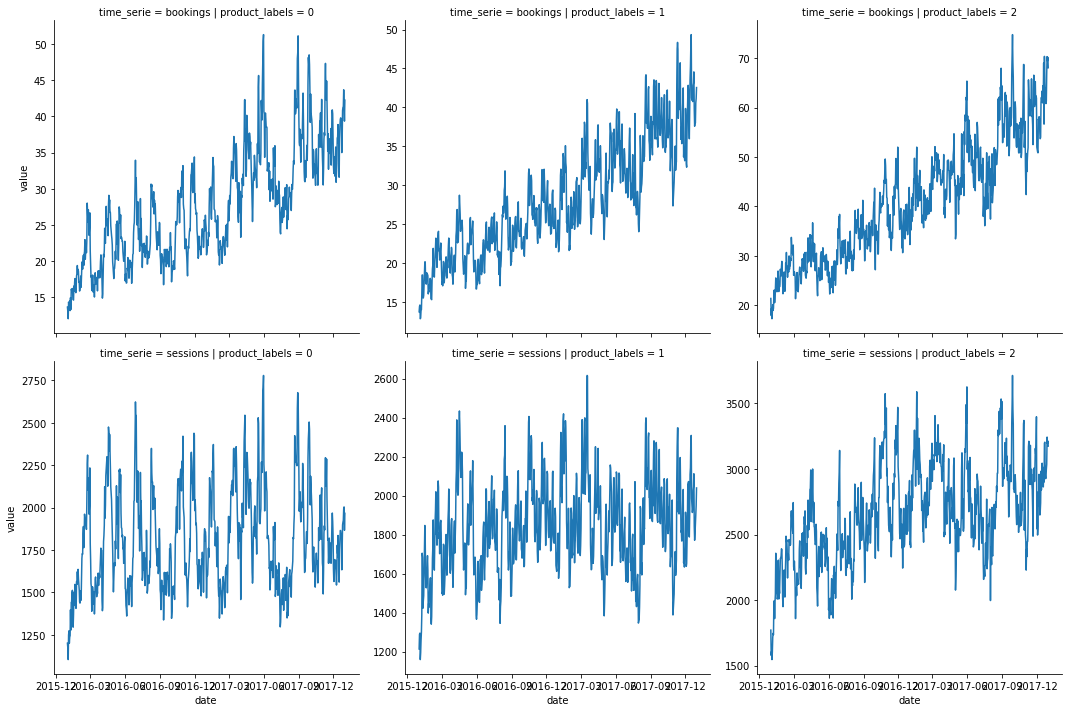

In [971]:
dt_plot = dt_unpivot.set_index('date').loc[datetime.datetime(2016,1,1):,:]
g = sns.relplot(data = dt_plot.reset_index(), kind = 'line', x = 'date', 
            y = 'value', col = 'product_labels', row = 'time_serie', facet_kws={'sharey':False})

Since 2016, the pattern seems to be stationary. We will then consider only data fom this period for the sessions. We can try to understand what led this pattern to change looking at the exogenous variables.
Also it seems that the bookings time serie has a variable variance along the time. This might be a problem that we will need to solve.

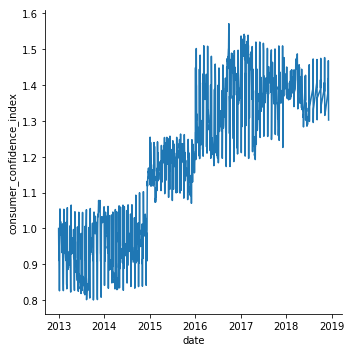

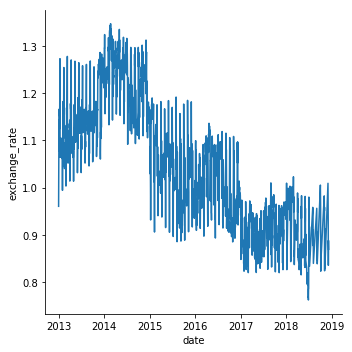

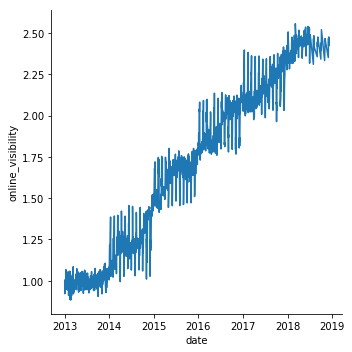

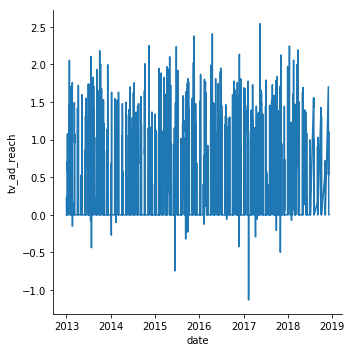

In [972]:
for i in meta.columns[1:-1]:
    sns.relplot(data = meta, x = 'date', y = i, kind = 'line')

There is no obvious break in the pattern in 2016. We will then model the training set in the following configuration: by product type and starting from 2016.

## FORECAST

We will use an ARIMA model, to model the product type time series. We could do the same process by product_id but for computation sake we will start with product type.
First we will automate the search for the best paramaters with cross validation. Then we will refit the model on the full data and finally forecast the product type series. To fill the the test set, we will map the product type prediction with the product id.
In the end, we will have 3 models, one for each product type. 

#### Grid search for ARIMA params

In [982]:
def split_dt(dt, cutoff, min_train_date_config, time_serie):
    # Find cutoff date
    cutoff_train_date = dt.index.get_level_values('date')[round(cutoff*dt.shape[0])-1]
    # split train/test set
    min_train_date = min_train_date_config[time_serie]
    train = dt.xs(slice(min_train_date, cutoff_train_date),level='date', drop_level=False)
    test = dt.xs(slice(cutoff_train_date+datetime.timedelta(days = 1), None),level='date', drop_level=False)
    #dt.loc[:cutoff_train_date,:], dt.loc[cutoff_train_date+datetime.timedelta(days = 1):,:]
    return train,test, cutoff_train_date

def evaluate_arima_model(dt, cutoff, *split_args, **arima_kwargs):
    # split into train/test set
    train, test, cutoff_train_date = split_dt(dt, cutoff, *split_args)
    # Fit model
    #dt_reindexed = dt.reset_index([0,2], drop=True)
    train = train.reset_index([0,2], drop=True)
    model = sm.tsa.statespace.SARIMAX(endog = train,**arima_kwargs)
    results = model.fit()
    # Make prediction on test set
    predictions = results.get_prediction(start=cutoff_train_date+datetime.timedelta(days = 1),
                                        end = dt.index.get_level_values(level = 'date')[-1], dynamic=False)
    y_pred = predictions.predicted_mean 
    # Calculate test RMSE
    error = math.sqrt(mean_squared_error(test.values, y_pred))
    #print(f"order/seasonal: {arima_kwargs['order']}/{arima_kwargs['seasonal_order']}\nAIC : {results.aic} - RMSE : {error}")
    return results,error,results.aic

In [1048]:
# Format dataset
dt_unpivot.product_labels = dt_unpivot.product_labels.astype('object')
dt = dt_unpivot.set_index(['product_labels','date', 'time_serie'])
# Init the params for the grid search
p = q = range(0, 2)
d = range(0,3)
pdq = list(itertools.product(p, d, q))
P = D = Q = range(0,2)
M = [3,7]#,31,90,120]
# Init permutations of the params
seasonal_pdq = list(itertools.product(P, D, Q, M))
# Init params of the ARIMA that will be update for each permutation
kwargs = {'order':pdq, 'seasonal_order':seasonal_pdq,'enforce_stationarity':False,'enforce_invertibility':False}
min_train_date_config = {'bookings':None,'sessions':datetime.datetime(2016,1,1)}
# Init the loop paramas
time_series_list = dt.index.get_level_values(level = 'time_serie').unique()
product_type_list = dt.index.get_level_values(level = 'product_labels').unique()
res = []
# Loop in the params & in the product type
for j in pdq:
    kwargs.update({'order':j})
    for i in seasonal_pdq:
        kwargs.update({'seasonal_order':i})
        for time_serie in time_series_list:
            for product_type in product_type_list:
                arima_result, error, aic = evaluate_arima_model(dt.loc[(product_type,slice(None),time_serie),:]
                                                                ,.8,*[min_train_date_config,time_serie],**kwargs)
                res.append((time_serie, product_type, error, aic, j, i))
                inter_res = pd.DataFrame(res,columns = ['time_serie','product_labels','error','aic', 'pdq','pdqm'])
                inter_res.to_pickle('inter_res_save3.pickle')

KeyboardInterrupt: 

Extract the best params for each type and each time serie

In [976]:
# helper function to retrieve best res on a multiindex dataframe
def get_best_res(dt,res_index):
    res = dt.iloc[0:0,:]#drop(dt.index,inplace=False)
    for i in res_index:
        best_res_by_index = dt.copy()
        for c,j in enumerate(i):
            best_res_by_index = best_res_by_index.xs(key = j,level = c, drop_level=False)
        res = pd.concat([res,best_res_by_index],axis = 0)
    return res

In [1050]:
#Load data
dt_result = pd.read_pickle('inter_res_save3.pickle')
dt_result = dt_result.set_index(['time_serie', 'product_labels','pdq','pdqm'])
# Look for best res
min_err_idx = dt_result.groupby(level = [0,1])[['error']].idxmin().values
best_res = get_best_res(dt_result, min_err_idx.flatten())
best_res

error          aic
time_serie product_labels pdq       pdqm                                 
bookings   0              (0, 0, 0) (1, 0, 1, 7)    5.265348  6764.083976
           1              (0, 0, 0) (1, 0, 1, 7)    3.531659  5461.446916
           2              (0, 0, 0) (1, 0, 1, 7)    6.634925  6502.295267
sessions   0              (0, 0, 0) (0, 1, 0, 7)  296.365112  5092.733394
           1              (0, 0, 0) (0, 1, 0, 7)  271.203608  4804.777501
           2              (0, 0, 0) (0, 1, 0, 3)  307.932272  5008.811798

### Interpretation

Lets plot the prediction against the actual. And then the residuals to see if there is any obvious pattern

In [1053]:
# Helper function
def plot_pred(dt, cutoff,split_args,transformation = None,**kwargs):
    _,test, cutoff_train_date = split_dt(dt, cutoff, *split_args)
    arima_plot = evaluate_arima_model(dt, cutoff, *split_args,**kwargs) if transformation is None else evaluate_log_arima_model(dt, cutoff, *split_args,**kwargs)
    predictions = arima_plot[0].get_prediction(start=cutoff_train_date+datetime.timedelta(days = 1),
                                            end = test.index.get_level_values(level = 'date')[-1]
                                               , dynamic=False)
    y_pred = predictions.predicted_mean if transformation is None else np.exp(predictions.predicted_mean)
    dt_ax = dt.copy()
    dt_ax.index = dt_ax.index.get_level_values(level = 'date')
    ax = dt_ax.value.plot(label='observed', figsize=(20,5))
    y_pred.plot(ax=ax, label='Forecast')
    ax.set_xlabel('Date')
    plt.legend()
    plt.show()

def plot_all(dataset, params, plot_func, **kwargs_o):
    kwargs = {'order':None, 'seasonal_order':None,
              'enforce_stationarity':False,'enforce_invertibility':False}
    for i in params.index:
        pdq, seasonal_pdq = list(i[2]), list(i[3])
        kwargs.update({'order':pdq, 'seasonal_order':seasonal_pdq})
        plot_func(dataset.loc[(i[1],slice(None),i[0]),:],.8,[min_train_date_config,i[0]],**kwargs_o,**kwargs)

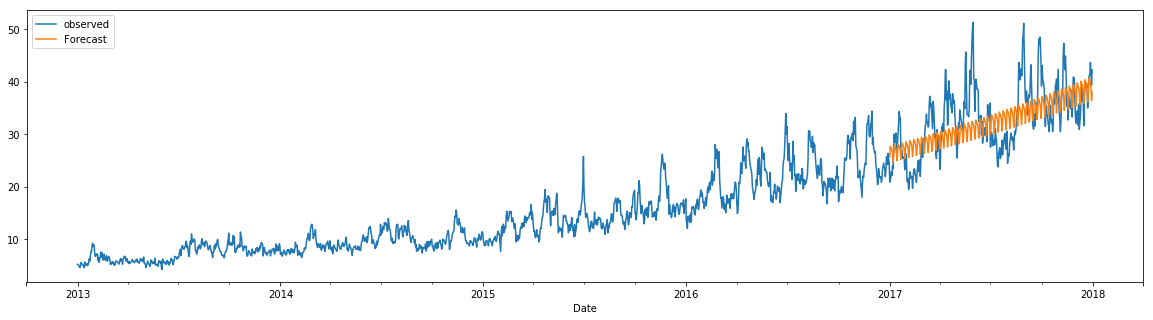

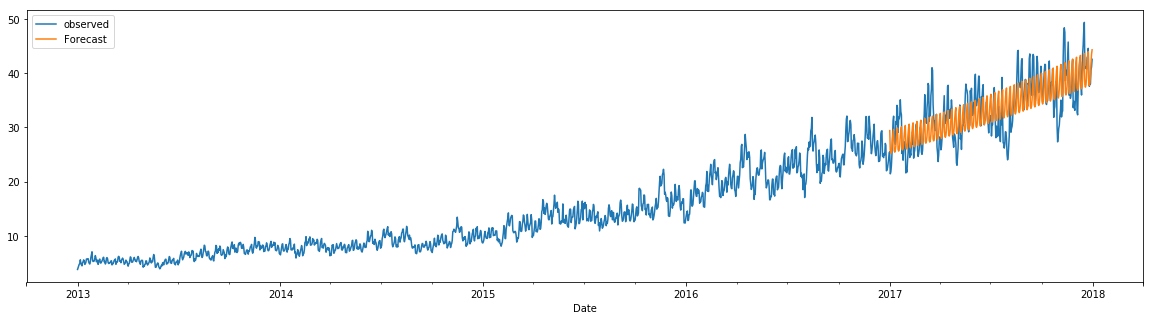

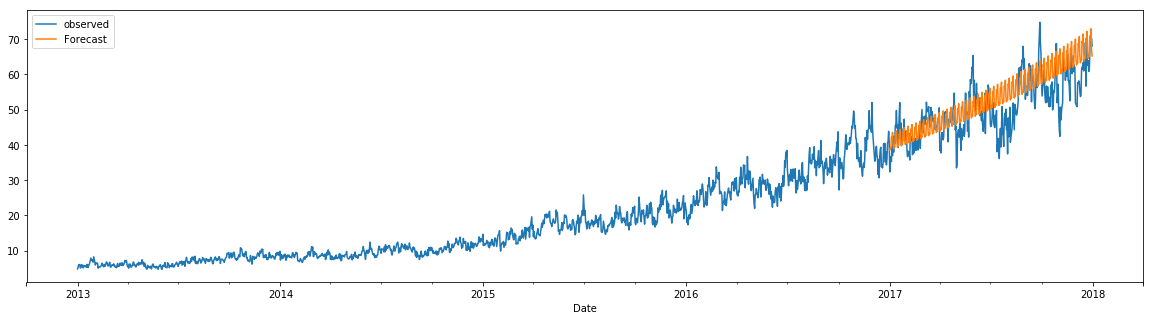

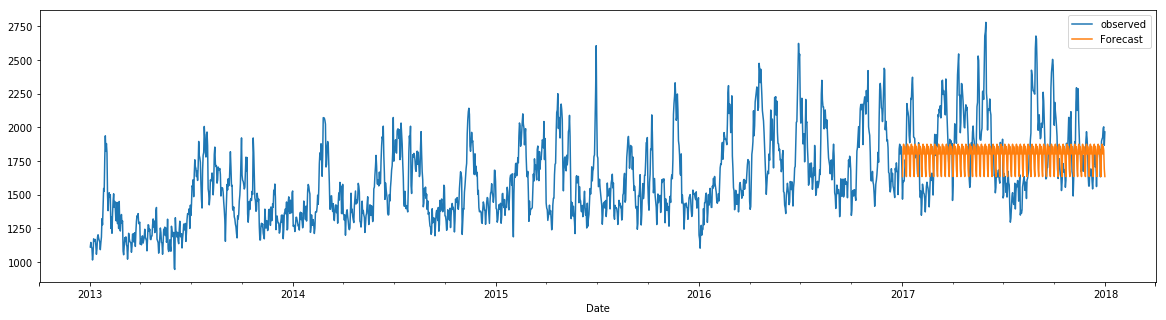

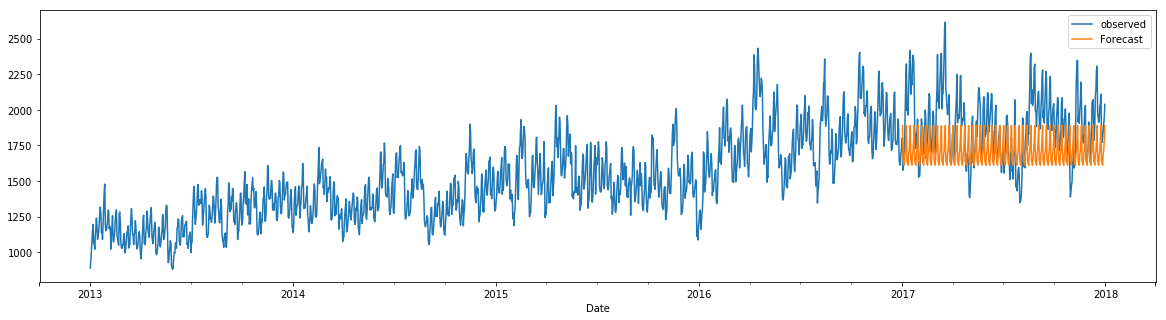

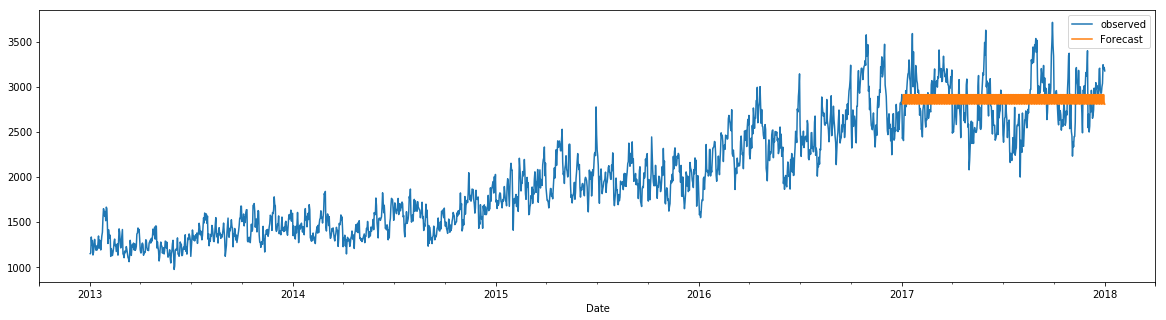

In [1054]:
plot_all(dt,best_res, plot_pred)

Lets look at the residuals to see if the model is flawed

In [1055]:
# Helper
def plot_resid(dt, cutoff, split_args,transformation = None, **kwargs):
    _,__, cutoff_train_date = split_dt(dt, cutoff, *split_args)
    arima_plot = evaluate_arima_model(dt, cutoff, *split_args,**kwargs) if transformation is None else evaluate_log_arima_model(dt, cutoff, *split_args,**kwargs)
    resid = arima_plot[0].resid if transformation is None else np.exp(arima_plot[0].resid)
    resid_plot = resid.plot(label='residuals', figsize=(20,5))
    resid_plot.set_ylabel('date')
    plt.legend()
    plt.show()
    plt.show()

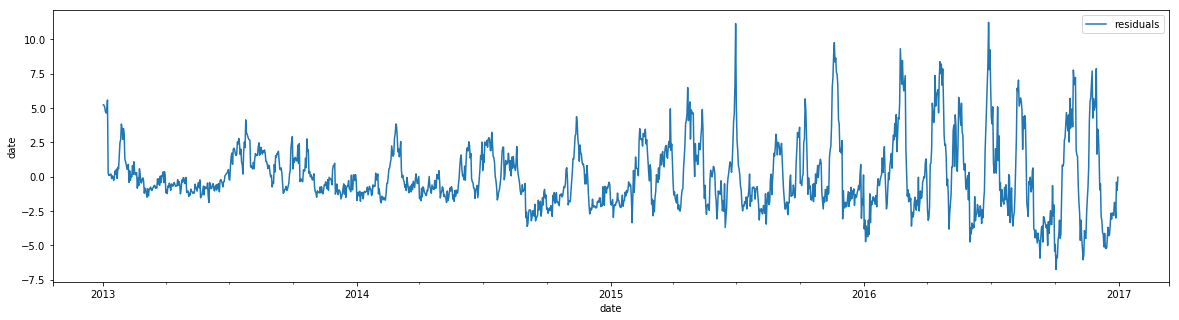

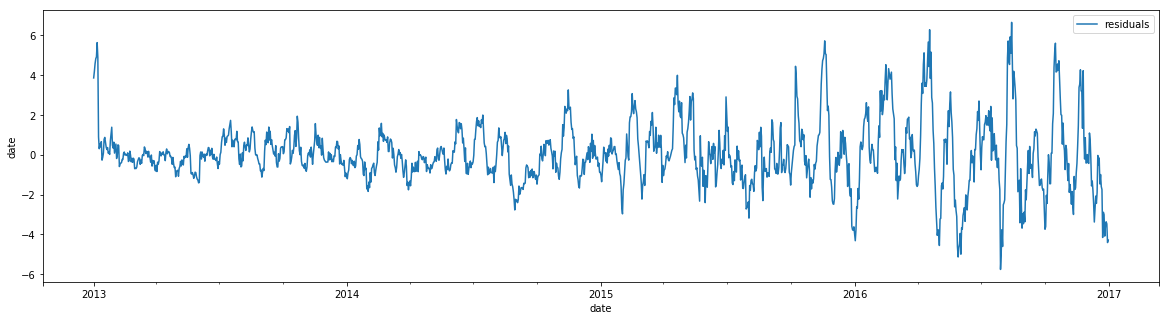

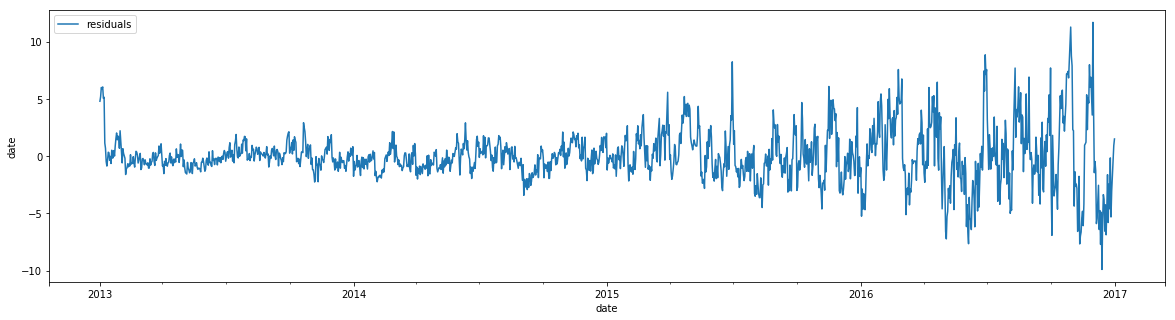

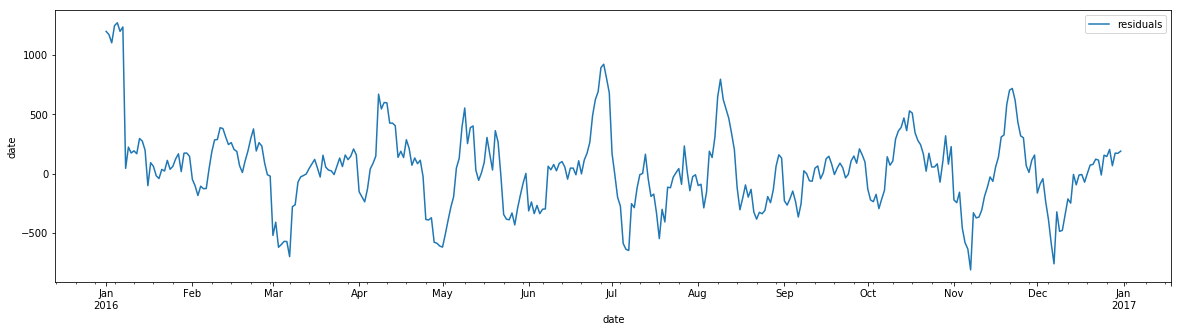

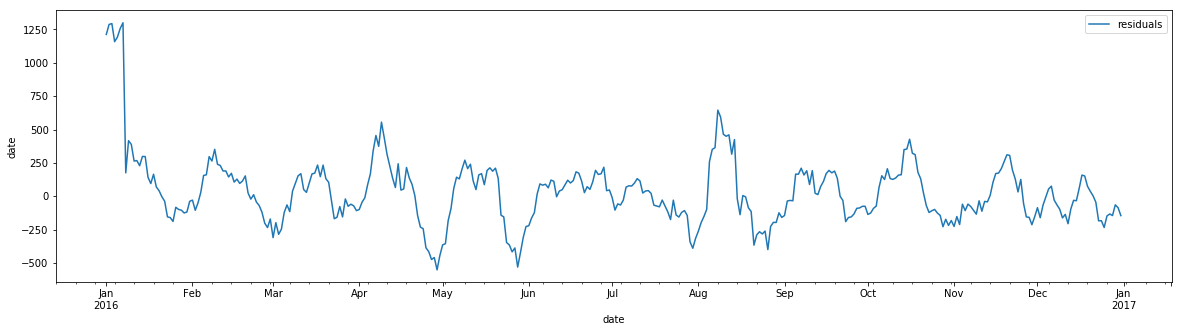

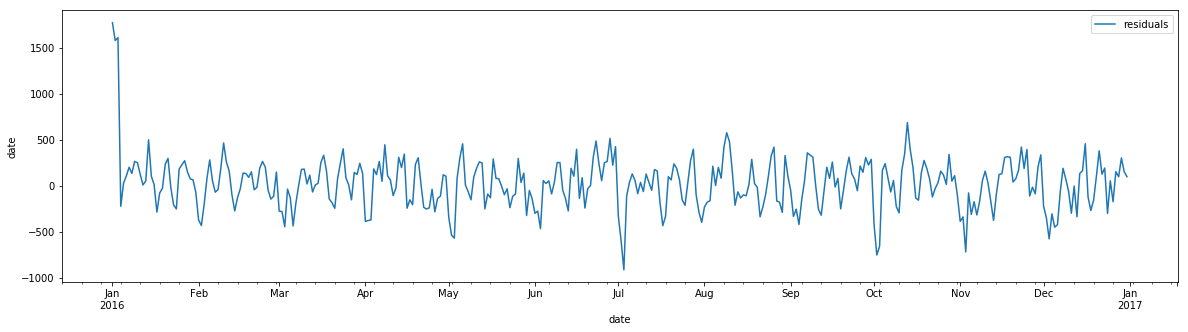

In [1056]:
plot_all(dt, best_res, plot_resid)

Globaly the residuals show a pattern with higher values and variances the more recent the date is. We will try to apply a log transformation.

### Improvements

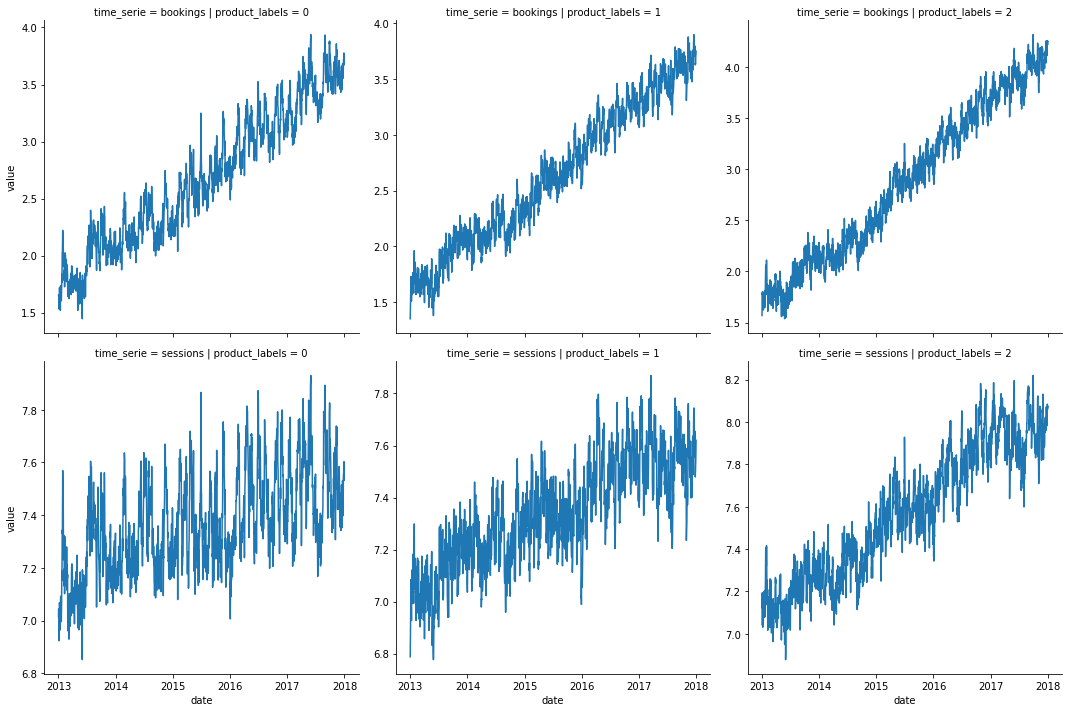

In [1057]:
dt_plot_log = dt_unpivot.copy()
dt_plot_log = dt_plot_log.set_index(['product_labels','date','time_serie'])
dt_plot_log = dt_plot_log.value.transform(math.log).to_frame()
g = sns.relplot(data = dt_plot_log.reset_index(), kind = 'line', x = 'date', 
            y = 'value', col = 'product_labels', row = 'time_serie', facet_kws={'sharey':False})

The variance unequality seems to have disapeared. Lets retrain the model on this new dataset

In [1058]:
#tune the model trainer function to train on log and evaluate on original value
def evaluate_log_arima_model(dt, cutoff, *split_args, **arima_kwargs):
    # split into train/test set
    train, test, cutoff_train_date = split_dt(dt, cutoff, *split_args)
    # Fit model
    train = train.reset_index([0,2], drop=True)
    #dt_reindexed = dt.reset_index([0,2], drop=True)
    model = sm.tsa.statespace.SARIMAX(endog = train.log_value,**arima_kwargs)
    results = model.fit()
    if cutoff < 1:
        # Make prediction on test set
        predictions = results.get_prediction(start=cutoff_train_date+datetime.timedelta(days = 1),
                                            end = dt.index.get_level_values(level = 'date')[-1], dynamic=False)
        y_pred = np.exp(predictions.predicted_mean) 
        # Calculate test RMSE
        error = math.sqrt(mean_squared_error(test.value, y_pred))
        return_t = (results,error,results.aic)
    else: return_t = results
    return return_t

In [1060]:
# Format dataset
dt_w_logs = pd.merge(right = dt_plot_log, left = dt, left_index=True, right_index=True)
dt_w_logs.columns = ['value','log_value']
# Init the params for the grid search
p = q = range(0, 2)
d = range(0,3)
pdq = list(itertools.product(p, d, q))
P = D = Q = range(0,2)
M = [3,7]#,31,90,120]
# Init permutations of the params
seasonal_pdq = list(itertools.product(P, D, Q, M))
# Init params of the ARIMA that will be update for each permutation
kwargs = {'order':pdq, 'seasonal_order':seasonal_pdq,'enforce_stationarity':False,'enforce_invertibility':False}
min_train_date_config = {'bookings':None,'sessions':datetime.datetime(2016,1,1)}
# Init the loop paramas
time_series_list = dt_w_logs.index.get_level_values(level = 'time_serie').unique()
product_type_list = dt_w_logs.index.get_level_values(level = 'product_labels').unique()
res = []
# Loop in the params & in the product type
for j in pdq:
    kwargs.update({'order':j})
    for i in seasonal_pdq:
        kwargs.update({'seasonal_order':i})
        for time_serie in time_series_list:
            for product_type in product_type_list:
                arima_result, error, aic = evaluate_log_arima_model(dt_w_logs.loc[(product_type,slice(None),time_serie),:]
                                                                ,.8,*[min_train_date_config,time_serie],**kwargs)
                res.append((time_serie, product_type, error, aic, j, i))
                inter_res = pd.DataFrame(res,columns = ['time_serie','product_labels','error','aic', 'pdq','pdqm'])
                inter_res.to_pickle('inter_log_res_save.pickle')

KeyboardInterrupt: 

In [1061]:
#Load data
dt_result_log = pd.read_pickle('inter_log_res_save.pickle')
dt_result_log = dt_result_log.set_index(['time_serie', 'product_labels','pdq','pdqm'])
# Look for best res
min_err_idx = dt_result_log.groupby(level = [0,1])[['error']].idxmin().values
best_res_log = get_best_res(dt_result_log, min_err_idx.flatten())
best_res_log

error          aic
time_serie product_labels pdq       pdqm                                 
bookings   0              (0, 0, 0) (1, 0, 1, 7)    5.907224 -1295.321854
           1              (0, 0, 0) (1, 0, 1, 7)    4.372199 -2377.108096
           2              (0, 0, 0) (1, 0, 0, 7)    6.526761 -1764.577159
sessions   0              (0, 0, 0) (0, 1, 0, 7)  296.365112  -295.403064
           1              (0, 0, 0) (1, 1, 1, 7)  214.130792  -646.739784
           2              (0, 0, 0) (0, 1, 0, 3)  307.932272  -654.130945

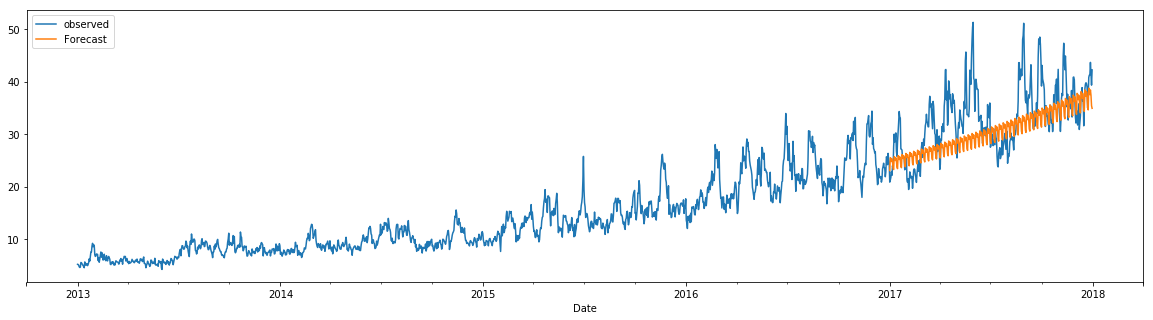

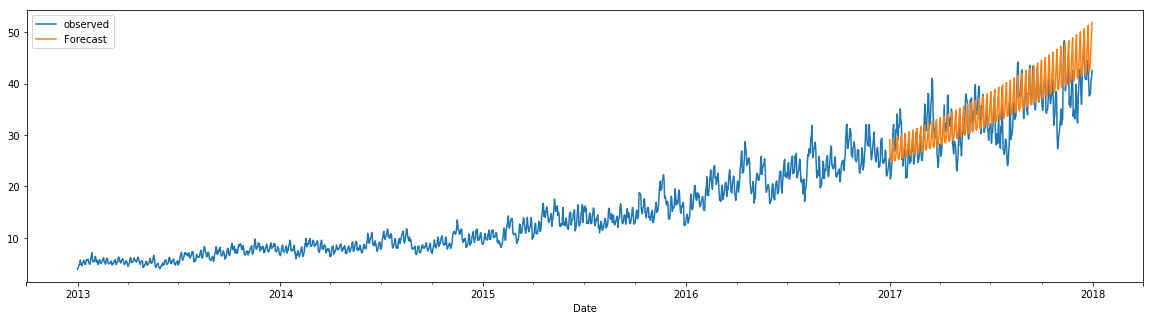

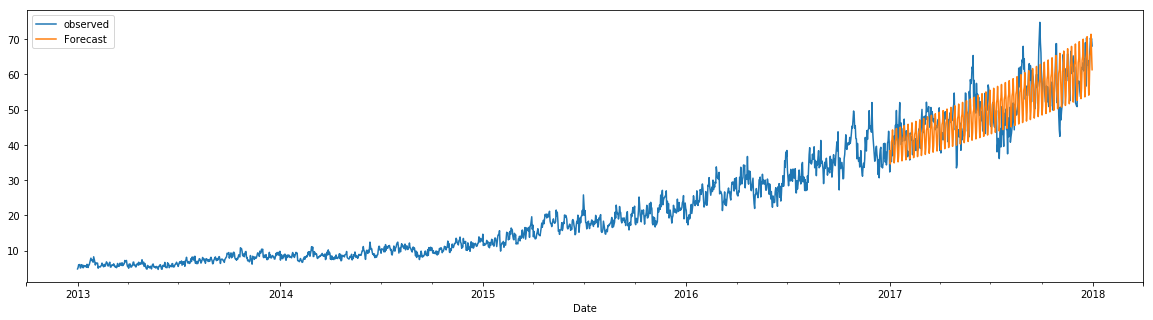

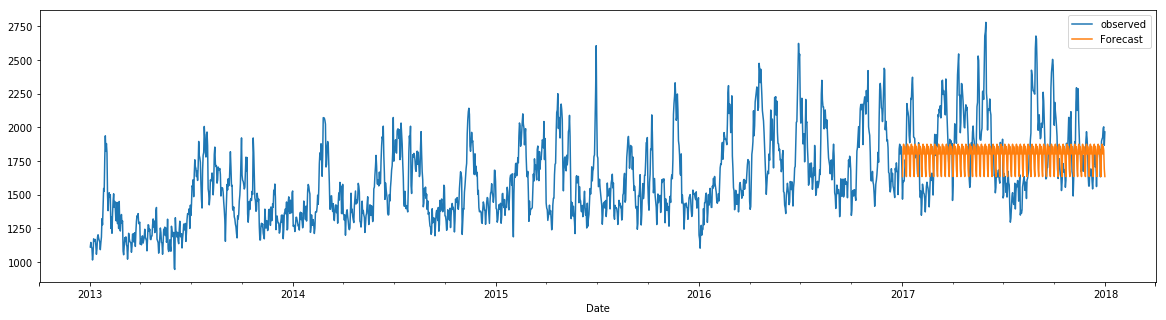

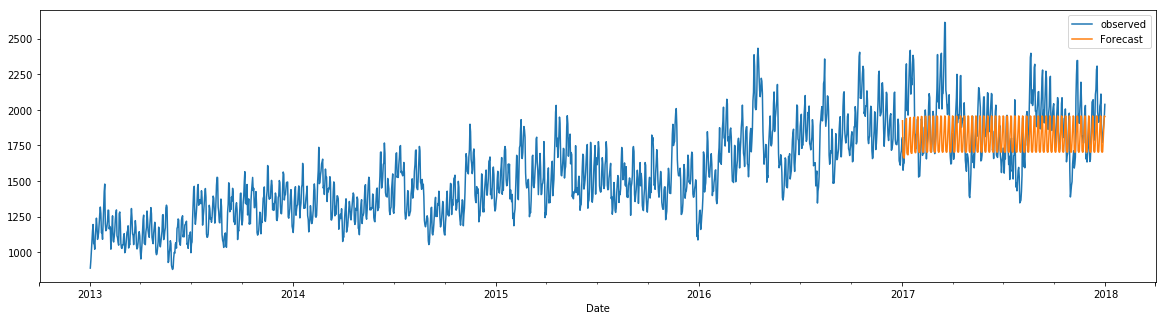

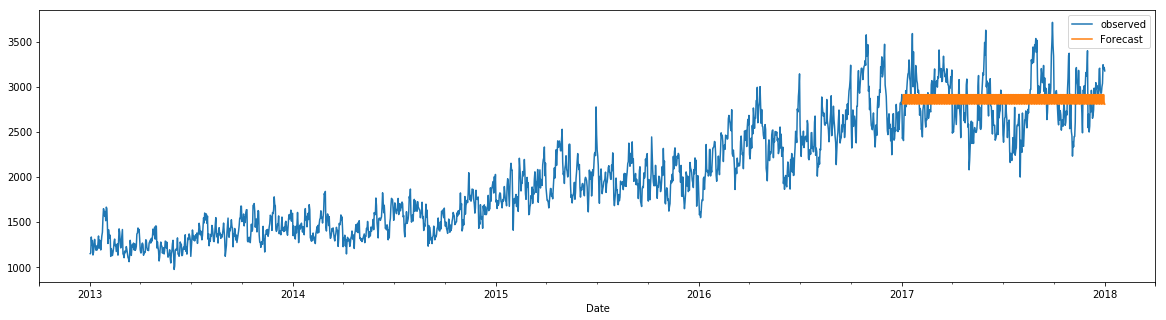

In [1062]:
plot_all(dt_w_logs, best_res_log, plot_pred, **{'transformation' : True})

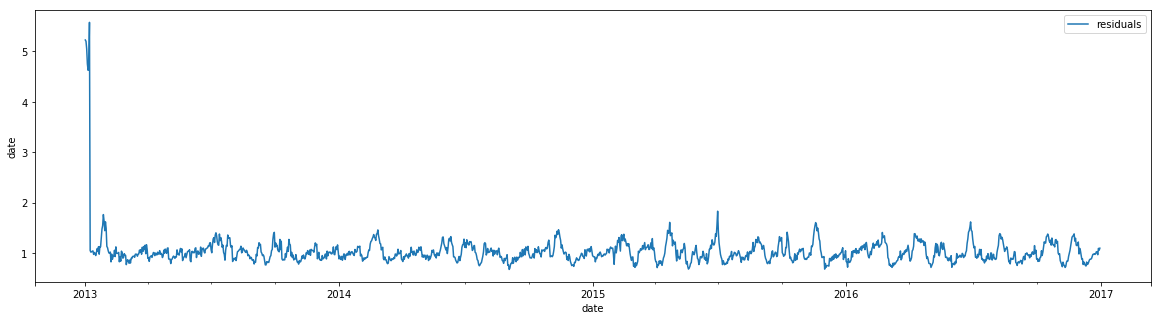

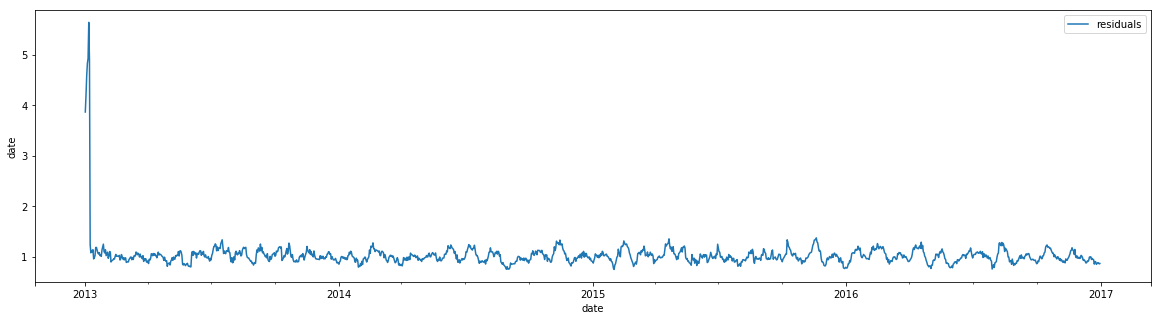

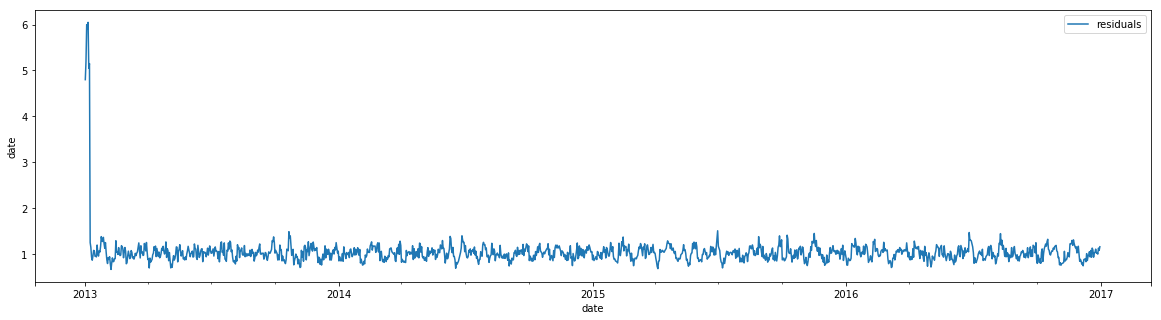

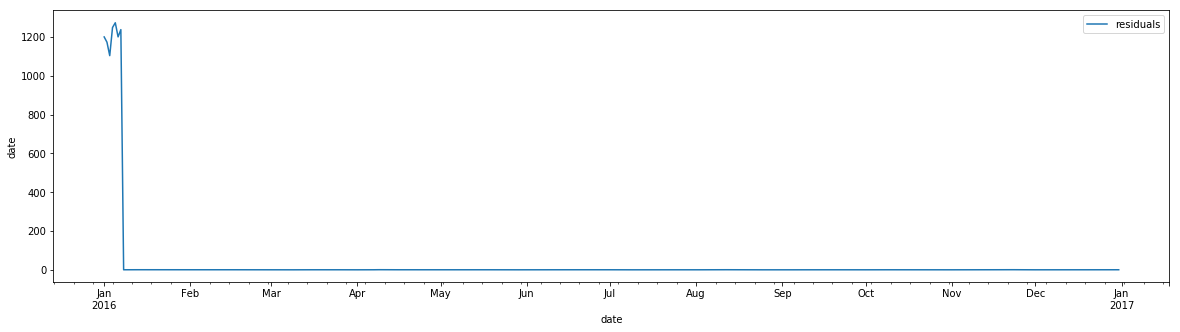

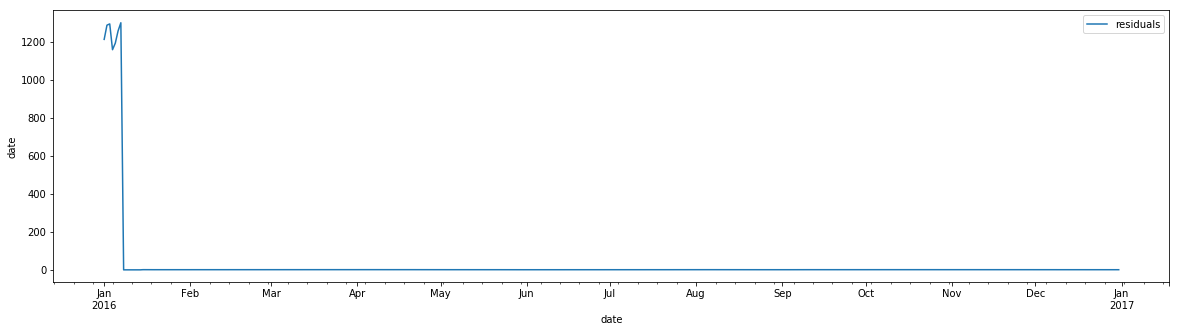

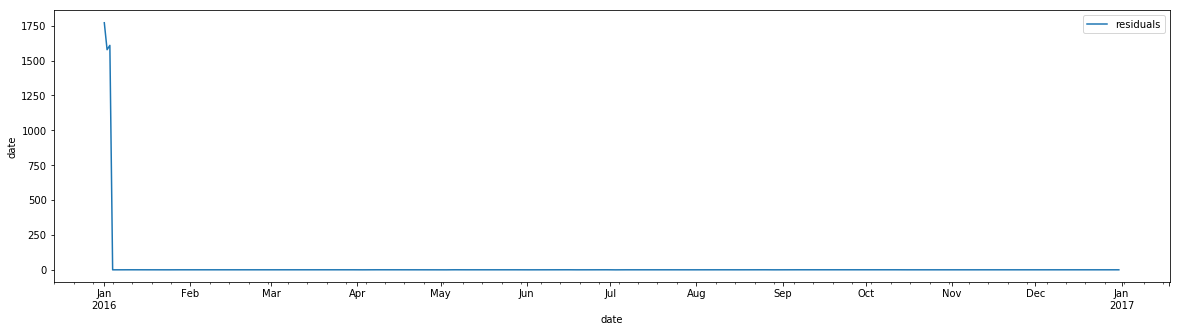

In [1066]:
plot_all(dt_w_logs, best_res_log, plot_resid,**{'transformation' : True})

It seems more balanced. We will use this configuration for the final prediction

### FORECAST
First we need to retrain the model with the complete dataset, then forecast one the test period. Then map the product ids to the product type.

In [1070]:
#Helper
def retrain_all(dataset, params):
    kwargs = {'order':None, 'seasonal_order':None,
              'enforce_stationarity':False,'enforce_invertibility':False}
    res = []
    for i in best_res_log.index:
        pdq, seasonal_pdq = list(i[2]), list(i[3])
        kwargs.update({'order':pdq, 'seasonal_order':seasonal_pdq})
        arima_result = evaluate_log_arima_model(dataset.loc[(i[1],slice(None),i[0]),:], 1, *[min_train_date_config,i[0]],**kwargs)
        res.append([i[0],i[1],arima_result])
    return res        

In [1071]:
retrained_model = retrain_all(dt_w_logs, best_res_log)

Now we forecast the results on the time period given by the submission dataset

In [1072]:
result = pd.DataFrame()
pred_set = pd.read_csv('test_data_raw/otb_interview_task__test__product_time_series.csv')
prediction_period = pd.to_datetime(pred_set.date)
for i in retrained_model:
    predictions = i[2].get_prediction(start=prediction_period[0],end = prediction_period[len(prediction_period)-1], dynamic=False)
    y_pred = np.exp(predictions.predicted_mean)
    res_int = pd.DataFrame(y_pred, columns = ['predicted'], index=y_pred.index)
    res_int['time_serie'] = i[0]
    res_int['product_labels'] = i[1]
    result = pd.concat([result,res_int], axis = 0)

Map results from product_type to product_id

In [1073]:
product_map = pd.read_csv('results/otb_interview_task__test__product_groupings_results.csv')
dt_by_prod = pd.merge(left = result.reset_index(), right = product_map )
dt_by_prod = dt_by_prod.set_index(['index', 'product_id', 'time_serie'])
dt_by_prod = dt_by_prod.drop('product_labels', axis = 1).unstack('time_serie')
dt_by_prod.head()

predicted          
time_serie              bookings  sessions
index      product_id                     
2018-01-01 0           39.952453  1897.775
           1           39.952453  1897.775
           2           39.952453  1897.775
           3           61.362350  3194.650
           4           39.952453  1897.775

In [839]:
dt_by_prod.to_csv('results/otb_interview_task__test__product_time_series_results.csv')